# Optimization Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils import *
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0,4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray' 

## 1 - Gradient Descent

In [2]:
def update_parameters_with_gd(parameters , grads , learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate*grads["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate*grads["db"+str(l+1)]
    
    return parameters

In [3]:
parameters,grads,learning_rate = update_parameters_with_gd_test_case()
parameters = update_parameters_with_gd(parameters , grads , learning_rate)
print("W1" + str(parameters["W1"]))
print("b1" + str(parameters["b1"]))
print("W2" + str(parameters["W2"]))
print("b2" + str(parameters["b2"]))

W1[[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1[[ 1.74604067]
 [-0.75184921]]
W2[[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2[[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


In Stochastic Gradient Descent, you use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here is an illustration of this: 

<img src="images/kiank_sgd.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **SGD vs GD**<br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>

**Note** also that implementing SGD requires 3 for-loops in total:
1. Over the number of iterations
2. Over the $m$ training examples
3. Over the layers (to update all parameters, from $(W^{[1]},b^{[1]})$ to $(W^{[L]},b^{[L]})$)

In practice, you'll often get faster results if you do not use neither the whole training set, nor only one training example, to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples.

<img src="images/kiank_minibatch.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u>: <font color='purple'>  **SGD vs Mini-Batch GD**<br> "+" denotes a minimum of the cost. Using mini-batches in your optimization algorithm often leads to faster optimization. </center></caption>

# 2 - Mini-Batch Gradient Descent

In [4]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches=[]
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation].reshape((1,m))
    
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X , mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m%mini_batch_size !=0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:m]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:m]
        mini_batch = (mini_batch_X , mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [5]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


# 3 - Momentum

<img src="images/opt_momentum.png" style="width:400px;height:250px;">
<caption><center> <u><font color='purple'>**Figure 3**</u><font color='purple'>: The red arrows shows the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, we let the gradient influence $v$ and then take a step in the direction of $v$.<br> <font color='black'> </center>

In [6]:
def initialize_velocity(parameters):
    L = len(parameters)//2
    v={}
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        v["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
    return v

In [7]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

v["dW1"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db1"] = [[ 0.]
 [ 0.]]
v["dW2"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db2"] = [[ 0.]
 [ 0.]
 [ 0.]]


$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.  Note that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift `l` to `l+1` when coding.

In [8]:
def update_parameters_with_momentum(parameters , grads , v , beta , learning_rate):
    L = len(parameters)//2
    for l in range(L):
        v["dW"+str(l+1)] = beta*v["dW"+str(l+1)]+(1-beta)*grads["dW"+str(l+1)]
        v["db"+str(l+1)] = beta*v["db"+str(l+1)]+(1-beta)*grads["db"+str(l+1)]
        
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate*v["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate*v["db"+str(l+1)]
        
    return parameters,v

In [9]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))

W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[ 0.02344157]
 [ 0.16598022]
 [ 0.07420442]]


**Note** that:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$. 

# 4 - Adam
**How does Adam work?**
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

The update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

As usual, we will store all parameters in the `parameters` dictionary  

In [10]:
def initialize_adam(parameters):
    L = len(parameters)//2
    v={}
    s={}
    for l in range(L):
        v["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        v["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
        s["dW"+str(l+1)] = np.zeros(parameters["W"+str(l+1)].shape)
        s["db"+str(l+1)] = np.zeros(parameters["b"+str(l+1)].shape)
    return v,s

In [11]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

v["dW1"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db1"] = [[ 0.]
 [ 0.]]
v["dW2"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db2"] = [[ 0.]
 [ 0.]
 [ 0.]]
s["dW1"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]]
s["db1"] = [[ 0.]
 [ 0.]]
s["dW2"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
s["db2"] = [[ 0.]
 [ 0.]
 [ 0.]]


$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$

In [12]:
def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    L = len(parameters)//2
    v_corrected={}
    s_corrected={}
    for l in range(L):
        v["dW"+str(l+1)] = beta1*v["dW"+str(l+1)] + (1-beta1)*grads["dW"+str(l+1)]
        v["db"+str(l+1)] = beta1*v["db"+str(l+1)] + (1-beta1)*grads["db"+str(l+1)]
        
        v_corrected["dW"+str(l+1)] = v["dW"+str(l+1)]/(1-beta1**t)
        v_corrected["db"+str(l+1)] = v["db"+str(l+1)]/(1-beta1**t)
        
        s["dW"+str(l+1)] = beta2*s["dW"+str(l+1)] + (1-beta2)*(grads["dW"+str(l+1)]**2)
        s["db"+str(l+1)] = beta2*s["db"+str(l+1)] + (1-beta2)*(grads["db"+str(l+1)]**2)
        
        s_corrected["dW"+str(l+1)] = s["dW"+str(l+1)]/(1-beta2**t)
        s_corrected["db"+str(l+1)] = s["db"+str(l+1)]/(1-beta2**t)
        
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate*(v_corrected["dW"+str(l+1)])/((s_corrected["dW"+str(l+1)]**0.5)+epsilon)
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate*(v_corrected["db"+str(l+1)])/((s_corrected["db"+str(l+1)]**0.5)+epsilon)
        
    return parameters , v ,s

In [13]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print("v[\"dW1\"] = " + str(v["dW1"]))
print("v[\"db1\"] = " + str(v["db1"]))
print("v[\"dW2\"] = " + str(v["dW2"]))
print("v[\"db2\"] = " + str(v["db2"]))
print("s[\"dW1\"] = " + str(s["dW1"]))
print("s[\"db1\"] = " + str(s["db1"]))
print("s[\"dW2\"] = " + str(s["dW2"]))
print("s[\"db2\"] = " + str(s["db2"]))

W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09244991 -0.16498684]]
b2 = [[-0.88529979]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[ 0.02344157]
 [ 0.16598022]
 [ 0.07420442]]
s["dW1"] = [[ 0.00121136  0.00131039  0.00081287]
 [ 0.0002525   0.00081154  0.00046748]]
s["db1"] = [[  1.51020075e-05]
 [  8.75664434e-04]]
s["dW2"] = [[  7.17640232e-05   2.81276921e-04   4.78394595e-04]
 [  1.57413361e-04   4.72206320e-04   7.14372576e-04]
 [  4.50571368e-04   1.60392066e-07   1.24838242e-03]]
s["db2"] = [[  5.49507194e-05]
 [  2.75494327e-03]
 [  5.50629536e-04]]


# 5 - Model with different optimization algorithms

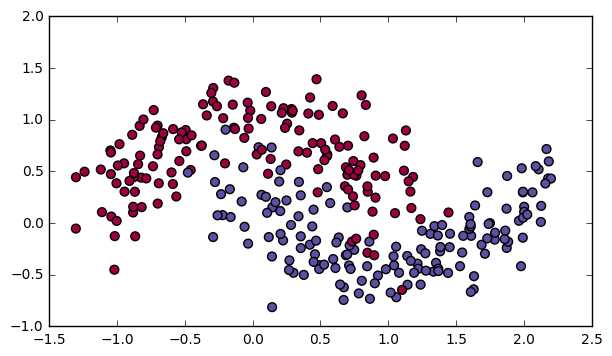

In [14]:
train_X , train_Y = load_dataset()

In [35]:
def model(X,Y,layers_dims,optimizer,learning_rate=0.0007,mini_batch_size=64, beta=0.9,beta1=0.9,beta2=0.999,epsilon=1e-8,num_epochs=10000,print_cost=True):
    L = len(layers_dims)
    costs=[]
    t=0
    seed = 10
    
    parameters = initialize_parameters(layers_dims)
    
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
        
    for i in range(num_epochs):
        seed = seed +1 
        minibatches  = random_mini_batches(X,Y,mini_batch_size,seed)
        
        for minibatch in minibatches:
            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)        
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

## 5.1 - Mini-batch gradient descent 

Cost after epoch 0: 0.690736
Cost after epoch 1000: 0.685273
Cost after epoch 2000: 0.647072
Cost after epoch 3000: 0.619525
Cost after epoch 4000: 0.576584
Cost after epoch 5000: 0.607243
Cost after epoch 6000: 0.529403
Cost after epoch 7000: 0.460768
Cost after epoch 8000: 0.465586
Cost after epoch 9000: 0.464518


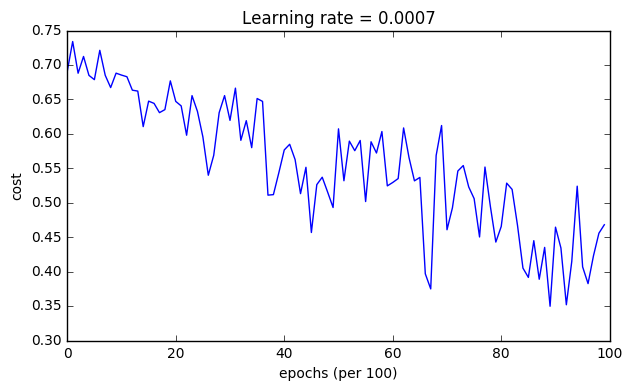

Accuracy: 0.796666666667


/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


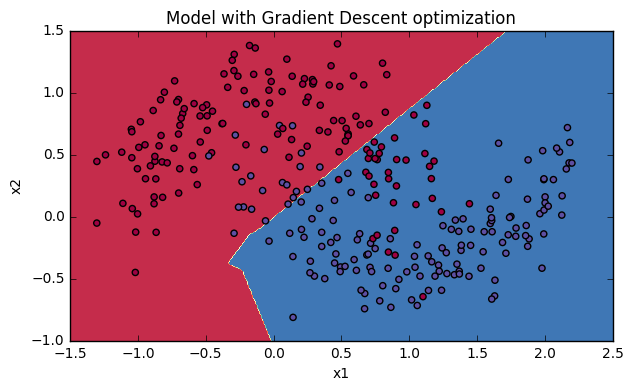

In [37]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 5.2 - Mini-batch gradient descent with momentum

Cost after epoch 0: 0.690741
Cost after epoch 1000: 0.685341
Cost after epoch 2000: 0.647145
Cost after epoch 3000: 0.619594
Cost after epoch 4000: 0.576665
Cost after epoch 5000: 0.607324
Cost after epoch 6000: 0.529476
Cost after epoch 7000: 0.460936
Cost after epoch 8000: 0.465780
Cost after epoch 9000: 0.464740


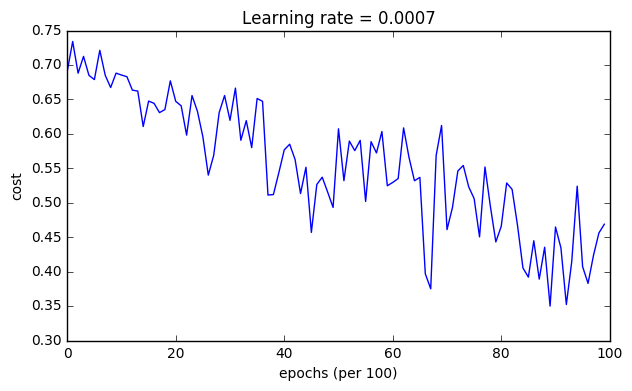

Accuracy: 0.796666666667


/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


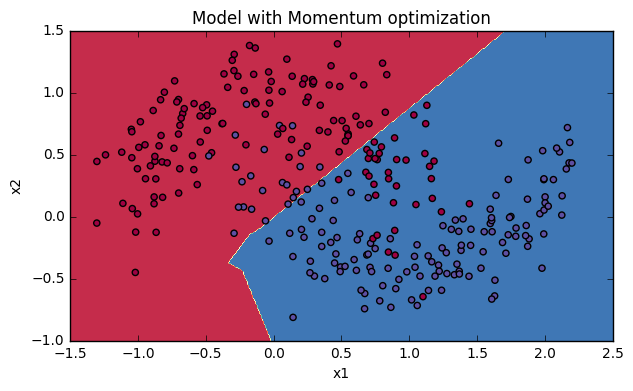

In [40]:
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X , train_Y , layers_dims , beta=0.9 , optimizer="momentum")
predictions = predict(train_X , train_Y , parameters)
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T),train_X, train_Y)

## 5.3 - Mini-batch with Adam mode

Cost after epoch 0: 0.690552
Cost after epoch 1000: 0.185567
Cost after epoch 2000: 0.150852
Cost after epoch 3000: 0.074454
Cost after epoch 4000: 0.125936
Cost after epoch 5000: 0.104235
Cost after epoch 6000: 0.100552
Cost after epoch 7000: 0.031601
Cost after epoch 8000: 0.111709
Cost after epoch 9000: 0.197648


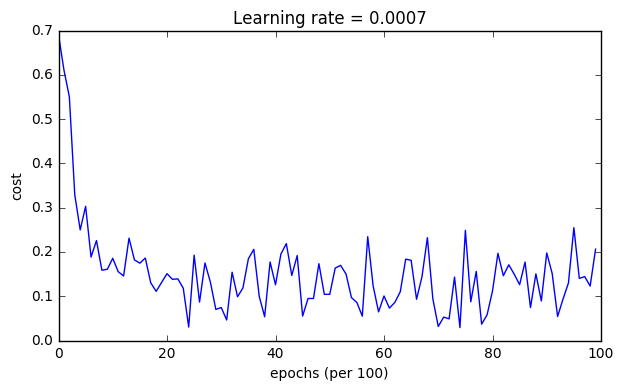

Accuracy: 0.94


/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/devendra/anaconda3/envs/dlnd-tf-lab/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


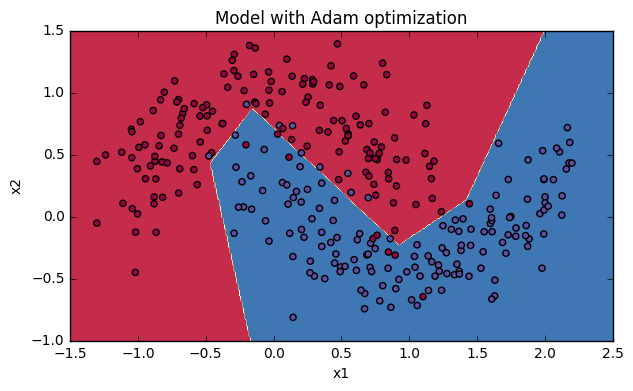

In [43]:
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X , train_Y , layers_dims , optimizer="adam")
predictions = predict(train_X , train_Y , parameters)
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)